# Data Generation

Generating training, validation data and solving instances

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed

from utils.data import generate_instance, solve

sns.set_theme()

## Solution time vs solution quality

In [2]:
def solve_wrapper(*args, **kwargs):
    routes, solver = solve(*args, **kwargs)

    return solver.solution.ObjectiveValue() if solver.solution else 0

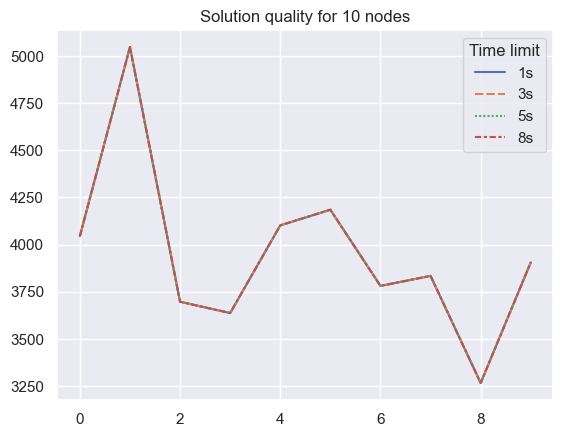

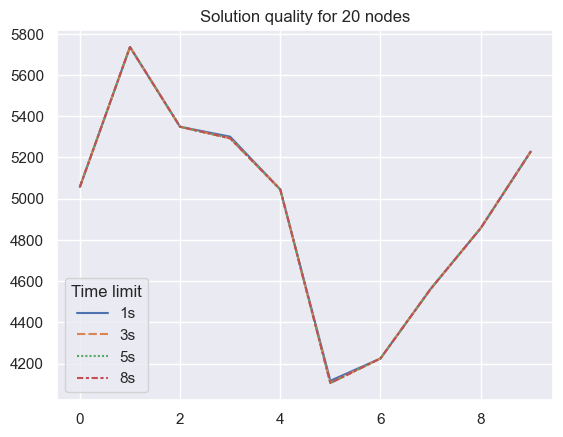

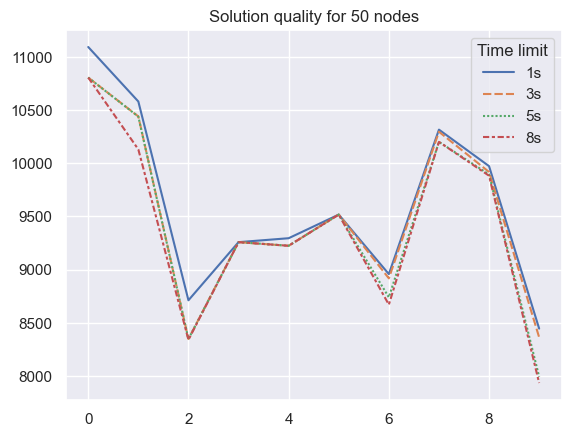

In [80]:
np.random.seed(42)

for nodes in [10, 20, 50]:
    instances = [generate_instance(nodes) for _ in range(10)]

    objective_values = np.zeros((10, 4))

    for j, time_limit in enumerate([1, 3, 5, 8]):
        solutions = Parallel(n_jobs=-1)(
            delayed(solve_wrapper)(
                instance,
                time_limit=time_limit,
                first_solution_strategy="PATH_CHEAPEST_ARC",
            )
            for instance in instances
        )

        objective_values[:, j] = solutions

    ax = sns.lineplot(data=objective_values)
    h, l = ax.get_legend_handles_labels()
    plt.title(f"Solution quality for {nodes} nodes")
    plt.legend(title="Time limit", handles=h, labels=["1s", "3s", "5s", "8s"])
    plt.show()

In [10]:
instances = [generate_instance(50) for _ in range(10)]

objective_values = np.zeros((len(instances), 3))

for j, strategy in enumerate(("SAVINGS", "AUTOMATIC", "PATH_CHEAPEST_ARC")):
    solutions = Parallel(n_jobs=-1)(
        delayed(solve_wrapper)(instance, time_limit=3, first_solution_strategy=strategy)
        for instance in instances
    )

    objective_values[:, j] = solutions

(9406.0, 13405.0)

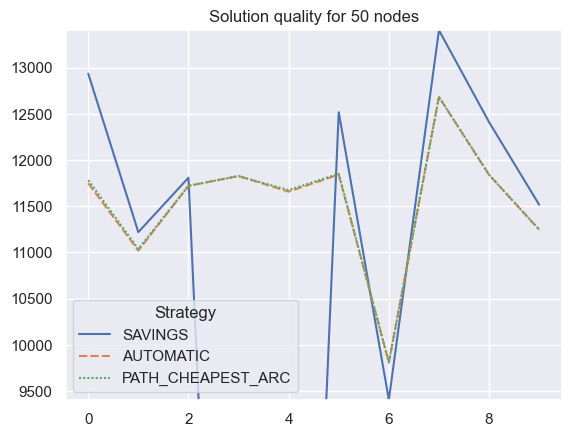

In [12]:
_max = np.max(objective_values[objective_values > 0])
_min = np.min(objective_values[objective_values > 0])

ax = sns.lineplot(data=objective_values)
h, l = ax.get_legend_handles_labels()
plt.title(f"Solution quality for 50 nodes")
plt.legend(
    title="Strategy", handles=h, labels=["SAVINGS", "AUTOMATIC", "PATH_CHEAPEST_ARC"]
)
ax.set_ylim(_min, _max)